In [1]:
def hash_list(l):
    r=l[0]
    #print(r)
    for e  in l:
        #print(e)
        r=hash((r, e))
        #print(r)
    return hash(r)


def hash_edge(G, u,v):
    return hash_list(sorted([hash(G.nodes[u]['atomic_num']),hash(G.nodes[v]['atomic_num']),hash(G.edges[u,v]['bond_type'])]))

def hash_neighborhood(G,u):
    ns = list(G.neighbors(u))
    es = sorted([hash_edge(G,u,v) for v in ns])
    GH = hash_list(es)
    return GH

def hash_bf_tree(G, u):
    # find all nodes at distance 2,3,4,...
    dist=0
    GH=list()
    nodes_layer_dist_from_u=sorted(list(nx.descendants_at_distance(G, u, dist)))
    while(len(nodes_layer_dist_from_u)!=0): 
        ns=sorted([hash_neighborhood(G,u) for u in sorted(nodes_layer_dist_from_u)])
        GH.append(hash_list(ns))
        #print(dist)
        dist+=1
        nodes_layer_dist_from_u=sorted(list(nx.descendants_at_distance(G, u, dist)))
    GH=hash_list(GH)
    return GH


def graph_hash(G):
    #es = sorted([hash_bf_tree(G,u) for u in sorted(G.nodes())])
    es = sorted([hash_neighborhood(G,u) for u in sorted(G.nodes())])
    GH = hash_list(es)
    return GH

def graph_hash2(G):
    #es = sorted([hash_bf_tree(G,u) for u in sorted(G.nodes())])
     #hash everything together
    es = sorted([hash_bf_tree(G,u) for u in sorted(G.nodes())])
    GH = hash_list(es)
    return GH

In [11]:
import requests
import numpy as np
from scipy.stats import rayleigh
from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
data=random.rayleigh(size=150)
import scipy.stats as st
st.t.interval(alpha=0.95, df=len(data)-1, loc=3.2, scale=st.sem(data)) 


C:\Users\cs843\AppData\Local\Temp\ipykernel_35836\3682945964.py:3: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))


(1.1754626328053703, 1.3928220175119805)

In [5]:
mean

array(1.25331414)

In [1]:
import pandas as pd
import pandas as pd
import requests
import numpy as np
import time
import io
from io import StringIO
import networkx
import networkx as nx
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Draw
def download_smiles_given_cids_from_pubmed(list_of_cids,chunk_size = 200): #returns df of smiles and cids
    df_smiles = pd.DataFrame()

    num_cids = len(list_of_cids)
    list_dfs = []
    if num_cids % chunk_size == 0 :
        num_chunks = int( num_cids / chunk_size )
    else :
        num_chunks = int( num_cids / chunk_size ) + 1

    #print("# CIDs = ", num_cids)
    #print("# CID Chunks = ", num_chunks, "(chunked by ", chunk_size, ")")

    for i in range(0, num_chunks) :
        idx1 = chunk_size * i
        idx2 = chunk_size * (i + 1)
        cidstr = ",".join( str(x) for x in list_of_cids[idx1:idx2] )

        url = ('https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/' + cidstr + '/property/IsomericSMILES/TXT')
        res = requests.get(url)
        data = pd.read_csv( StringIO(res.text), header=None, names=['smiles'] )
        list_dfs.append(data)
        
        time.sleep(0.2)
        
        #if ( i % 5 == 0 ) :
            #print("Processing Chunk ", i)
    df_smiles = pd.concat(list_dfs,ignore_index=True)
    df_smiles[ 'cid' ] = list_of_cids   

    return df_smiles

In [32]:
df=download_smiles_given_cids_from_pubmed([7044 , 15417  ],chunk_size = 200)

In [33]:
def mol_to_nx(mol):
    G = nx.Graph()
    
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   dg=atom.GetDegree(),
                   charge=atom.GetFormalCharge(),
                   hyb=atom.GetHybridization(),
                   is_aromatic=atom.GetIsAromatic(),
                   Hs=atom.GetTotalNumHs(),
                   rad=atom.GetNumRadicalElectrons,
                   ring=atom.IsInRing(),
                   chirality=atom.GetChiralTag())
        
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType())
        
    return G

In [35]:
smiles=list(df['smiles'])
smiles

['C1CCC2CCCCC2C1', 'C1CCC(C1)C2CCCC2']

In [37]:
def list_of_smiles_to_list_of_graph_molecules(list_of_smiles):
   list_of_molecules=[Chem.MolFromSmiles(smiles) for smiles in list_of_smiles] 
   print(len(list_of_molecules),len(list_of_smiles ))
   i=0
   list_of_graph_molecules=[]
   for mol in list_of_molecules:
      try:
          list_of_graph_molecules.append(mol_to_nx(mol))
          i=i+1
      except:
          print(i)
          list_of_graph_molecules.append('None')
          i=i+1
   return list_of_graph_molecules

In [47]:
G11=list_of_smiles_to_list_of_graph_molecules(smiles)[0]
G22=list_of_smiles_to_list_of_graph_molecules(smiles)[1]
print(graph_hash(G11),graph_hash(G22))
graph_hash2(G11),graph_hash2(G22)

2 2
2 2
-1697918920241208787 -1697918920241208787


(-1289011200600322872, -2271598820615431233)

In [48]:
G11.nodes[0]
G11.edges(data=True)

EdgeDataView([(0, 1, {'bond_type': rdkit.Chem.rdchem.BondType.SINGLE}), (0, 9, {'bond_type': rdkit.Chem.rdchem.BondType.SINGLE}), (1, 2, {'bond_type': rdkit.Chem.rdchem.BondType.SINGLE}), (2, 3, {'bond_type': rdkit.Chem.rdchem.BondType.SINGLE}), (3, 4, {'bond_type': rdkit.Chem.rdchem.BondType.SINGLE}), (3, 8, {'bond_type': rdkit.Chem.rdchem.BondType.SINGLE}), (4, 5, {'bond_type': rdkit.Chem.rdchem.BondType.SINGLE}), (5, 6, {'bond_type': rdkit.Chem.rdchem.BondType.SINGLE}), (6, 7, {'bond_type': rdkit.Chem.rdchem.BondType.SINGLE}), (7, 8, {'bond_type': rdkit.Chem.rdchem.BondType.SINGLE}), (8, 9, {'bond_type': rdkit.Chem.rdchem.BondType.SINGLE})])

In [50]:
import random
def permute_graph(G_orig):
    G = G_orig.copy()
    node_map = [u for u in G.nodes()]
    random.shuffle(node_map)
    node_map = {v:u for u,v in zip(node_map, G.nodes())}
    G = nx.relabel_nodes(G, node_map)
    #print(G.nodes)
    return G

In [51]:
def plot_graph(G):
    pos=nx.kamada_kawai_layout(G)
    node_labels = {u:G.nodes[u]['node_label'] for u in G.nodes()}
    nx.draw_networkx(G, pos, with_labels=True)
    #nx.draw_networkx_labels(G,pos, labels=node_labels)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


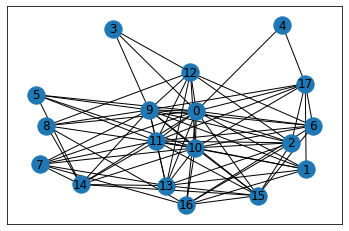

In [52]:
import networkx as nx
n=18
m=8
G = nx.barabasi_albert_graph(n, m) 
label_alphabet = ['a','b','c']
for u in G.nodes():
    G.nodes[u]['node_label']=random.choice(label_alphabet)
nx.set_edge_attributes(G,1,'edge_label')  
plot_graph(G)
print(G.nodes)

[16, 12, 15, 5, 13, 10, 8, 0, 9, 1, 2, 11, 3, 7, 4, 6, 14, 17]


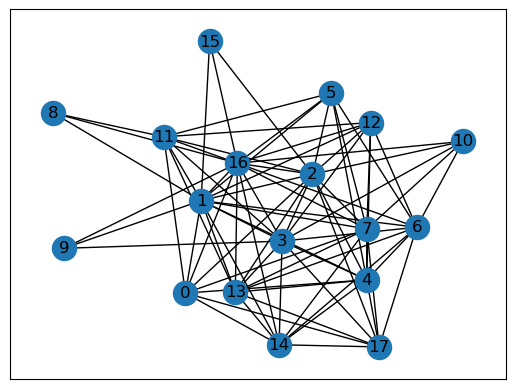

In [766]:
G2 = permute_graph(G)
print(G2.nodes)
plot_graph(G2)

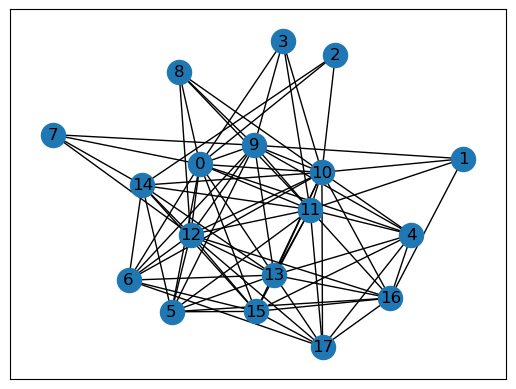

In [701]:
G3 = G.copy()
es = [e for e in G.edges()]
ns = [u for u in G.nodes()]
random.shuffle(ns)
G3.remove_edge(*es[0])
G3.add_edge(ns[0], ns[1], edge_label=1)
plot_graph(G3)

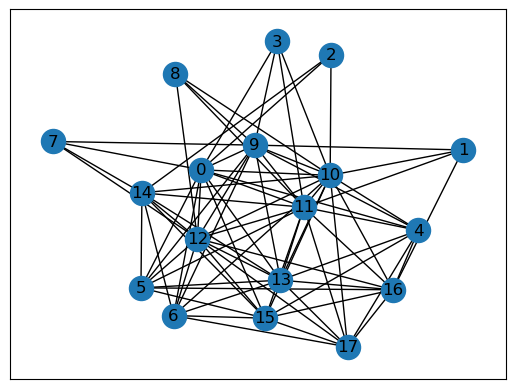

In [702]:
G4 = G3.copy()
es = [e for e in G3.edges()]
ns = [u for u in G3.nodes()]
random.shuffle(ns)
G4.remove_edge(*es[6])
G4.add_edge(ns[0], ns[1], edge_label=1)
plot_graph(G4)

In [704]:
list(nx.descendants_at_distance(G3, 2, 2))
#G3.neighbors(0)
#G3.number_of_edges()

[1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17]

In [705]:
from networkx import dfs_tree
tree=nx.descendants_at_distance(G3, 1,3)
tree
#check_up_to_what_distance_you_can_get_neighbours_against_your_given_distance


set()

In [706]:
graph_hash(G),graph_hash(G2), graph_hash(G3)

(-29098510120178217, -29098510120178217, 1226311227803041421)

In [707]:
graph_hash2(G),graph_hash2(G2),graph_hash2(G3)

(-1050565459512667757, -1050565459512667757, -1254818149880285257)

In [735]:
ns = [1,3,8,12,34]
from itertools import combinations
list(combinations(ns, r=3))

[(1, 3, 8),
 (1, 3, 12),
 (1, 3, 34),
 (1, 8, 12),
 (1, 8, 34),
 (1, 12, 34),
 (3, 8, 12),
 (3, 8, 34),
 (3, 12, 34),
 (8, 12, 34)]

In [760]:
import networkx as nx
import itertools
def generate_subgraphs_of_size_k(G,k=3,no_samples=500 ):
    list_of_subgraphs=[]
    for SG in (G.subgraph(s) for s in combinations(G, k)):
        list_of_subgraphs.append(SG)
    print(len(list_of_subgraphs))
    return random.sample(list_of_subgraphs, no_samples)


In [746]:
generate_subgraphs_of_size_k(G2,k=4)

3060


In [747]:
generate_subgraphs_of_size_k(G2,k=5)

8568


In [740]:
generate_subgraphs_of_size_k(G2,k=6)

18564


In [748]:
generate_subgraphs_of_size_k(G2,k=7)

31824


In [749]:
generate_subgraphs_of_size_k(G2,k=8)

43758
